In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import rioxarray as rioxr
import geopandas as gpd

import warnings

import planetary_computer as pc

import gc # garbage collector

import dask
import dask_gateway
import dask.array as da
from dask_ml.wrappers import ParallelPostFit

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe
import data_sampling_workflow.utility as ut

In [23]:
campus_itemids = ['ca_m_3411934_sw_11_060_20200521',
                  'ca_m_3411934_sw_11_060_20180722_20190209',
                  'ca_m_3411934_sw_11_.6_20160713_20161004',
                  'ca_m_3411934_sw_11_1_20140601_20141030',
                  'ca_m_3411934_sw_11_1_20120505_20120730']

# Select NAIP scene and LIDAR year

In [22]:
# **************************************************************
# ********* SPECIFY ITEMID AND LIDAR YEAR TO MATCH HERE ********

itemid = campus_itemids[0] # NAIP scene over Conception Point
year = 2020

save_raster = False
filename = 'SPECTRAL_campus_'+str(year)+'_predictions.tif'

plot_predictions = True
graph_title = "SPECTRAL PREDICTIONS : "+str(year)+" campus point NAIP scene"

# **************************************************************
# **************************************************************

NameError: name 'campus_itemids' is not defined

In [ ]:
t_alpha = time.time()

# Import train/test sets

In [6]:
# select features from r (Red band) to avg_lidar
# excludes x,y, pts_crs, aoi, naip_id, polygon_id, iceplant and lidar features
X_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'r':'day_in_year']

# select iceplant feature column
y_train = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','train_set.csv')).loc[:,'iceplant'] 

In [11]:
# select test features and labels
X_test = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','test_set.csv')).loc[:,'r':'day_in_year']
y_test = pd.read_csv(os.path.join(os.getcwd(),'data_sampling_workflow','test_set.csv')).loc[:,'iceplant'] 
mpe.iceplant_proportions(y_test)

no-iceplant:iceplant ratio     1.8 :1
          counts  percentage
iceplant                    
0          93840       63.91
1          52992       36.09



In [8]:
mpe.iceplant_proportions(y_train)

no-iceplant:iceplant ratio     1.8 :1
          counts  percentage
iceplant                    
0         219292       64.01
1         123291       35.99



## Train model

In [9]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  39.17453193664551


In [12]:
predictions = rfc.predict(X_test)
mpe.print_threshold_metrics(y_test, predictions)


true negatives: 91504     false positives: 2336
false negatives: 2478     true positives: 50514

sensitivity (TP/P): 95.32 %
specificity (TN/N): 97.51 %
G-mean:  0.96

precision (TP/(TP+FP)): 95.58 %

MCC:  0.9288885758749532

F1-measure:  0.95452
F0.5-measure (min false positives):  0.95529
F2-measure (min false negatives)  :  0.95375

accuracy: 96.72 %



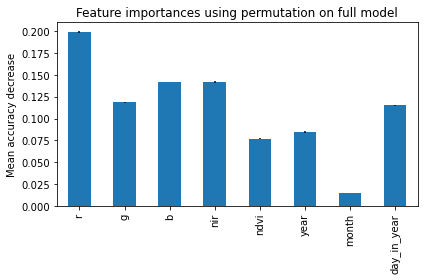

In [13]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 'year', 'month', 'day_in_year'])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

# Pre-process NAIP scene for prediction

In [5]:
from joblib import dump, load
import refactoring_modules as rm

In [6]:
rfc = load('rfc_trial.joblib') 

In [7]:
itemid = 'ca_m_3411934_sw_11_060_20200521'

raster = rm.rioxr_from_itemid(itemid)

is_veg, water_index, not_veg_index = rm.add_spectral_features(df = rm.raster_as_df(raster.to_numpy(), ['r','g','b','nir']), 
                                                           ndwi_thresh = 0.3, 
                                                           ndvi_thresh = 0.05) 
is_veg.drop('ndwi', axis=1, inplace=True)

is_veg = rm.add_date_features(is_veg, raster.datetime)

In [8]:
is_veg.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
83,79,101,86,147,0.300885,2020,5,142
84,71,98,73,158,0.379913,2020,5,142
85,95,118,82,180,0.309091,2020,5,142


# Make dask data array of pixel values from NAIP scene raster

In [9]:
da_pixels = da.from_array(np.array(is_veg), chunks=728802)
da_pixels

dask.array<array, shape=(24691336, 8), dtype=float64, chunksize=(728802, 8), chunktype=numpy.ndarray>

# Predict using dask

In [10]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
#cluster.adapt(minimum=4, maximum=50)
cluster.scale(30)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.c3e0130bb47c45248fa76633b59f7a6d/status,


In [11]:
scene_preds = rfc.predict(da_pixels)
scene_preds

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


dask.array<_predict, shape=(24691336,), dtype=int64, chunksize=(728802,), chunktype=numpy.ndarray>

In [12]:
t0 = time.time()
preds = scene_preds.compute()
print((time.time()-t0))

76.44063830375671


In [17]:
preds_df = pd.DataFrame(preds, 
                     columns=['is_iceplant'], 
                     index = is_veg.index)
is_iceplant_index = preds_df[preds_df.is_iceplant == 1].index.to_numpy()
non_iceplant_index = preds_df[preds_df.is_iceplant == 0].index.to_numpy()

(4, 12500, 10580)

In [21]:
indices = [non_iceplant_index,
           is_iceplant_index, 
           not_veg_index,
           water_index]
values = [0,
          1,
          2,
          3]

reconstruct = rm.indices_to_image(raster.shape[1], raster.shape[2], indices, values, back_value=100)
reconstruct

array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]])

# Convert predictions back to image

In [25]:
shape = item.properties['proj:shape']
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    nrows = shape[0]
    ncols = shape[1]
#    index = predictions_df[predictions_df.prediction == 1].index.to_numpy()
    preds = ipf.preds_to_image_3labels(nrows, ncols, df.index, preds)
    print('converted back to image')

converted back to image


## Plot predictions if required

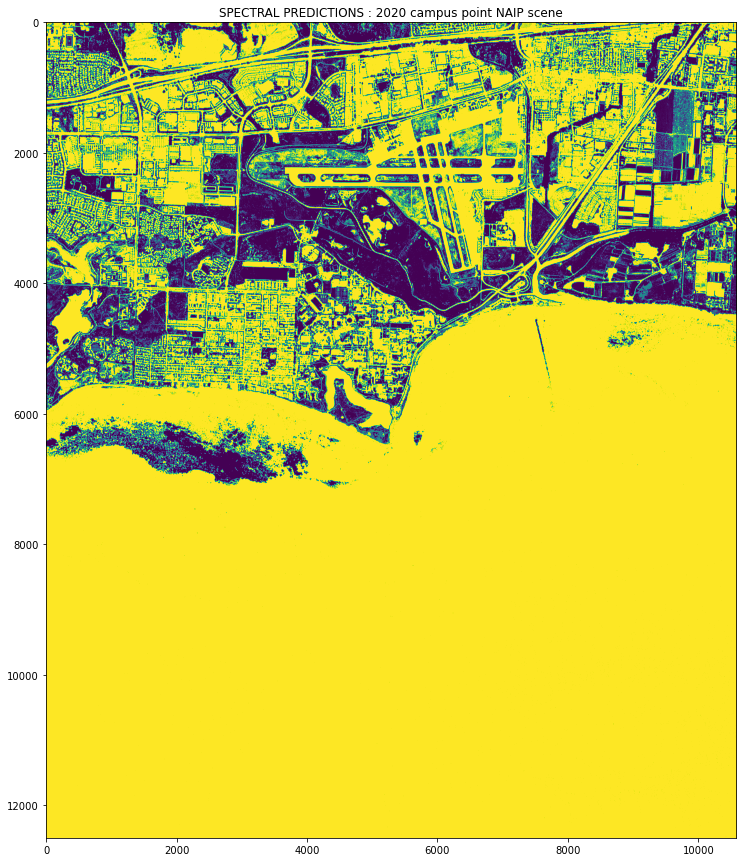

In [26]:
# # TO DO: make this into a three colours graph
# if plot_predictions == True:
#     fig, ax = plt.subplots(figsize=(15, 15))
#     plt.title(graph_title)
#     ax.imshow(preds)
#     plt.show()

## Save predictions if required

In [30]:
if save_raster == True:
    
    with rasterio.open(
        os.path.join(os.getcwd(),'temp',filename),  # file path
        'w',           # w = write
        driver = 'GTiff', # format
        height = preds.shape[0], 
        width = preds.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = rast.crs,
        transform = rast.transform,
    ) as dst:
        dst.write(preds.astype(rasterio.uint8), 1)

In [25]:
#print('total time:', time.time() - t_alpha )
rasterio.dtypes.get_minimum_dtype(reconstruct)

'float32'

In [26]:
np.unique(reconstruct)

array([0., 1., 2., 3.])

In [28]:
raster.rio.crs
ut.save_raster(reconstruct,
               os.getcwd()+'/trial_tif.tif',
               reconstruct.shape,
               1,
               crs = raster.rio.crs,
               transform= raster.rio.transform(),
               dtype = rasterio.uint8)


In [24]:
ut.save_raster??

Signature: ut.save_raster(raster, fp, shape, bands_n, crs, transform, dtype)
Source:   
def save_raster(raster, fp, shape, bands_n, crs, transform, dtype):
    """
        Saves an array as a 'GTiff' raster with specified parameters.
        Parameters:
                    raster (numpy.ndarray): array of raster values
                    fp (str): file path where raster will be saved
                    shape (tuple):shape of raster (height, width) TO DO: SHOULD THIS BE READ DIRECTLY FROM raster??
                    bands_n (integer): number of bands in the raster
                    crs (str): CRS of raster
                    transform (affine.Affine): affine transformation of raster
        Return: None
    """
    bands_array = 1
    if bands_n > 1:
        bands_array = np.arange(1,bands_n+1)
        
    with rasterio.open(
        fp,  # file path
        'w',           # w = write
        driver = 'GTiff', # format
        height = shape[0], 
        width = shape[1],
       